# xG Model

Build an Expected Goals (xG) model using the free StatsBomb event data. 

We have taken the pitch coordinates from StatsBomb documentation.

## 1. Read data

### Importing modules

In [1]:
import pandas as pd
import os
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from matplotlib.patches import Arc
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [2]:
def create_df(data):
    pitch_size = [120,80]
    goal_size = 8
    try:
        shot_list = []
        for event in data:
            if event['type']['name'] == 'Shot':
                shots = dict()
                shots['x_loc'] = event['location'][0]
                shots['y_loc'] = event['location'][1]
                x = pitch_size[0] - event['location'][0]
                y = pitch_size[1]/2 - event['location'][1]
                d = x**2 + y**2 - (goal_size/2)**2
                if d == 0: 
                    alpha = False
                else:
                    alpha = abs(np.arctan(goal_size*x /d))
                shots['distance'] = round(np.sqrt(x**2 + y**2),1)
                shots['angle'] = round(alpha,1)
                shots['minute'] = event['minute']
                shots['play_pattern'] = event['play_pattern']['name'] 
                shots['player_id'] = event['player']['id'] #mapping strong foot
                shots['body_part'] = event['shot']['body_part']['name']
                if 'first_time' in event['shot']:
                    shots['first_time'] = event['shot']['first_time']
                shots['outcome'] = event['shot']['outcome']['name']
                shots['technique'] = event['shot']['technique']['name']
                shots['type'] = event['shot']['type']['name']
                if 'key_pass_id' in event['shot']:
                    key_pass_id = event['shot']['key_pass_id']
                    key_pass = list(filter(lambda x:x["id"] == key_pass_id,data))[0]
                    shots['key_pass_angle'] = key_pass['pass']['angle']
                    shots['key_pass_length'] = key_pass['pass']['length']
                    shots['key_pass_height'] = key_pass['pass']['height']['name']
                shots['statsbomb_xg'] = event['shot']['statsbomb_xg']#compare
                triangle = Polygon([event['location'], [120,36], [120,44]])
                opp_players = 0
                if 'freeze_frame' in event['shot']:
                    for player in event['shot']['freeze_frame']:
                        if player['teammate'] == False and triangle.contains(Point(player['location'])):
                            opp_players += 1
                shots['opp_players'] = opp_players
                shot_list.append(shots) 
        df = pd.DataFrame(shot_list)
        return df

    except Exception as e: 
        print(e)    
    
def create_shots_df(path):
    files = os.listdir(path)
    try:
        df = pd.DataFrame()
        for file in files:
            file_path = f'{path}\{file}'  
            with open(file_path, 'r', encoding="utf8") as f:
                d = f.read()
            data = json.loads(d)
            df_match = create_df(data)
            df = df.append(df_match)
        return df
    
    except Exception as e: 
        print(e)

In [3]:
def draw_pitch(x_min=0, x_max=120,
               y_min=0, y_max=80,
               pitch_color="w",
               line_color="grey",
               line_thickness=1.5,
               point_size=20,
               orientation="horizontal",
               aspect="full",
               ax=None
               ):

    if not ax:
        raise TypeError("This function is intended to be used with an existing fig and ax in order to allow flexibility in plotting of various sizes and in subplots.")


    if orientation.lower().startswith("h"):
        first = 0
        second = 1
        arc_angle = 0

        if aspect == "half":
            ax.set_xlim(x_max / 2, x_max + 5)

    elif orientation.lower().startswith("v"):
        first = 1
        second = 0
        arc_angle = 90

        if aspect == "half":
            ax.set_ylim(x_max / 2, x_max + 5)

    
    else:
        raise NameError("You must choose one of horizontal or vertical")

    
    ax.axis("off")

    rect = plt.Rectangle((x_min, y_min),
                         x_max, y_max,
                         facecolor=pitch_color,
                         edgecolor="none",
                         zorder=-2)

    ax.add_artist(rect)

    x_conversion = x_max / 100
    y_conversion = y_max / 100

    pitch_x = [0,5.8,11.5,17,50,83,88.5,94.2,100] # pitch x markings
    pitch_x = [x * x_conversion for x in pitch_x]

    pitch_y = [0, 21.1, 36.6, 50, 63.2, 78.9, 100] # pitch y markings
    pitch_y = [x * y_conversion for x in pitch_y]

    goal_y = [45.2, 54.8] # goal posts
    goal_y = [x * y_conversion for x in goal_y]

    # side and goal lines
    lx1 = [x_min, x_max, x_max, x_min, x_min]
    ly1 = [y_min, y_min, y_max, y_max, y_min]

    # outer boxed
    lx2 = [x_max, pitch_x[5], pitch_x[5], x_max]
    ly2 = [pitch_y[1], pitch_y[1], pitch_y[5], pitch_y[5]]

    lx3 = [0, pitch_x[3], pitch_x[3], 0]
    ly3 = [pitch_y[1], pitch_y[1], pitch_y[5], pitch_y[5]]

    # goals
    lx4 = [x_max, x_max+2, x_max+2, x_max]
    ly4 = [goal_y[0], goal_y[0], goal_y[1], goal_y[1]]

    lx5 = [0, -2, -2, 0]
    ly5 = [goal_y[0], goal_y[0], goal_y[1], goal_y[1]]

    # 6 yard boxes
    lx6 = [x_max, pitch_x[7], pitch_x[7], x_max]
    ly6 = [pitch_y[2],pitch_y[2], pitch_y[4], pitch_y[4]]

    lx7 = [0, pitch_x[1], pitch_x[1], 0]
    ly7 = [pitch_y[2],pitch_y[2], pitch_y[4], pitch_y[4]]


    # Halfway line, penalty spots, and kickoff spot
    lx8 = [pitch_x[4], pitch_x[4]]
    ly8 = [0, y_max]

    lines = [
        [lx1, ly1],
        [lx2, ly2],
        [lx3, ly3],
        [lx4, ly4],
        [lx5, ly5],
        [lx6, ly6],
        [lx7, ly7],
        [lx8, ly8],
        ]

    points = [
        [pitch_x[6], pitch_y[3]],
        [pitch_x[2], pitch_y[3]],
        [pitch_x[4], pitch_y[3]]
        ]

    circle_points = [pitch_x[4], pitch_y[3]]
    arc_points1 = [pitch_x[6], pitch_y[3]]
    arc_points2 = [pitch_x[2], pitch_y[3]]


    for line in lines:
        ax.plot(line[first], line[second],
                color=line_color,
                lw=line_thickness,
                zorder=-1)

    for point in points:
        ax.scatter(point[first], point[second],
                   color=line_color,
                   s=point_size,
                   zorder=-1)

    circle = plt.Circle((circle_points[first], circle_points[second]),
                        x_max * 0.088,
                        lw=line_thickness,
                        color=line_color,
                        fill=False,
                        zorder=-1)

    ax.add_artist(circle)

    arc1 = Arc((arc_points1[first], arc_points1[second]),
               height=x_max * 0.088 * 2,
               width=x_max * 0.088 * 2,
               angle=arc_angle,
               theta1=128.75,
               theta2=231.25,
               color=line_color,
               lw=line_thickness,
               zorder=-1)

    ax.add_artist(arc1)

    arc2 = Arc((arc_points2[first], arc_points2[second]),
               height=x_max * 0.088 * 2,
               width=x_max * 0.088 * 2,
               angle=arc_angle,
               theta1=308.75,
               theta2=51.25,
               color=line_color,
               lw=line_thickness,
               zorder=-1)

    ax.add_artist(arc2)

    ax.set_aspect("equal")

    return ax

Reading data takes some time so we've saved the df as a txt file.

In [ ]:
# Using function
path = "Path_to_events_data_folder"
df = create_shots_df(path)

In [4]:
# Read from file
df = pd.read_csv('shots.txt', sep=';')

## 2. Preprocessing and EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28024 entries, 0 to 28023
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   x_loc            28024 non-null  float64
 1   y_loc            28024 non-null  float64
 2   distance         28024 non-null  float64
 3   angle            28024 non-null  float64
 4   minute           28024 non-null  int64  
 5   play_pattern     28024 non-null  object 
 6   player_id        28024 non-null  int64  
 7   body_part        28024 non-null  object 
 8   first_time       7860 non-null   object 
 9   outcome          28024 non-null  object 
 10  technique        28024 non-null  object 
 11  type             28024 non-null  object 
 12  key_pass_angle   19614 non-null  float64
 13  key_pass_length  19614 non-null  float64
 14  key_pass_height  19614 non-null  object 
 15  statsbomb_xg     28024 non-null  float64
 16  opp_players      28024 non-null  int64  
dtypes: float64(7

In [6]:
df.describe()

,x_loc,y_loc,distance,angle,minute,player_id,key_pass_angle,key_pass_length,statsbomb_xg,opp_players
count,28024.000000,28024.000000,28024.000000,28024.000000,28024.000000,28024.000000,19614.000000,19614.000000,28024.000000,28024.000000
mean,103.908468,39.727084,18.896250,0.442878,48.757208,12269.197759,-0.028452,23.623274,0.118427,1.672495
std,8.803051,9.875478,8.769517,0.262588,27.309999,9058.464273,1.482903,13.720232,0.158289,1.092322
min,40.000000,0.400000,0.700000,0.000000,0.000000,2941.000000,-3.127769,0.000000,0.000000,0.000000
25%,97.900000,32.300000,12.000000,0.300000,26.000000,5246.000000,-1.350598,12.700098,0.026821,1.000000
50%,105.300000,40.000000,17.900000,0.400000,49.000000,7063.500000,-0.141897,20.704346,0.054712,1.000000
75%,111.000000,47.000000,25.100000,0.600000,71.000000,16879.000000,1.325818,32.994165,0.133971,2.000000
max,120.100000,79.500000,81.400000,1.600000,128.000000,105762.000000,3.141593,111.511840,0.958827,11.000000


Convert goal variable into binary:

In [7]:
df['goal'] = np.where(df['outcome']== 'Goal', 1, 0)

Fill NaN values

In [8]:
df['first_time'] = df['first_time'].fillna(False)
df['key_pass_height'] = df['key_pass_height'].fillna('No')
df = df.fillna(0)

Count 'type' unique values

In [9]:
df['type'].value_counts()

Open Play    26044
Free Kick     1519
Penalty        455
Corner           5
Kick Off         1
Name: type, dtype: int64

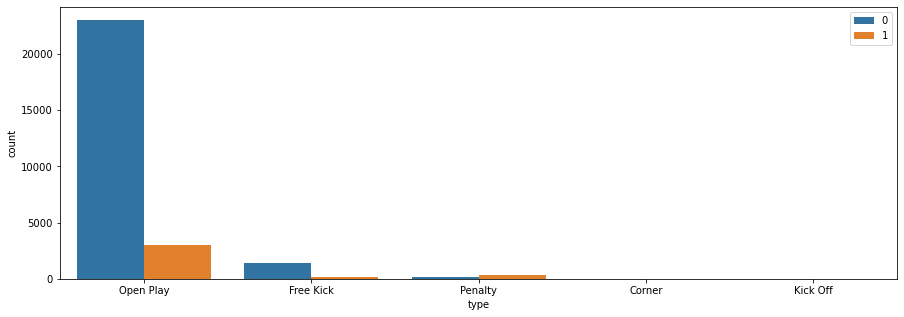

In [10]:
plt.subplots(1, figsize=(15,5))
ax=sns.countplot(x='type',hue='goal',data=df)
plt.legend(loc='upper right')

We are going to take into account the most common type "Open Play"

In [11]:
df = df[df['type'] == 'Open Play'].reset_index(drop=True)

In [12]:
df['play_pattern'].value_counts()

Regular Play      9837
From Throw In     4836
From Corner       4271
From Free Kick    4083
From Counter      1308
From Goal Kick     984
From Keeper        336
From Kick Off      319
Other               70
Name: play_pattern, dtype: int64

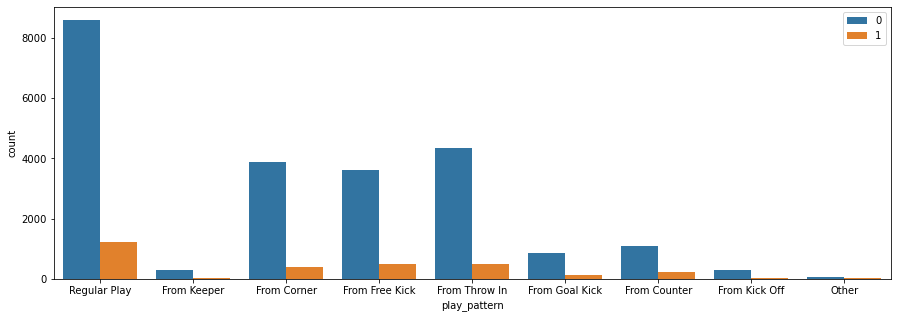

In [13]:
plt.subplots(1, figsize=(15,5))
ax=sns.countplot(x='play_pattern',hue='goal',data=df)
plt.legend(loc='upper right')

Body part values count, unify foot shots and drop 'Other'

In [14]:
df['body_part'].value_counts()

Right Foot    13637
Left Foot      8277
Head           4052
Other            78
Name: body_part, dtype: int64

In [15]:
df = df.replace({'body_part' : {'Right Foot' : 'Foot', 'Left Foot' : 'Foot'}})
df = df[df['body_part'] != 'Other'].reset_index(drop=True)

In [16]:
df['technique'].value_counts()

Normal           20893
Half Volley       2746
Volley            1651
Lob                338
Overhead Kick      135
Diving Header      103
Backheel           100
Name: technique, dtype: int64

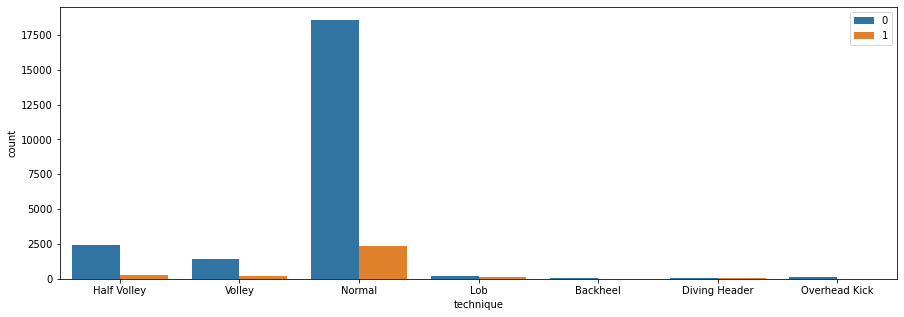

In [17]:
plt.subplots(1, figsize=(15,5))
ax=sns.countplot(x='technique',hue='goal',data=df)
plt.legend(loc='upper right')

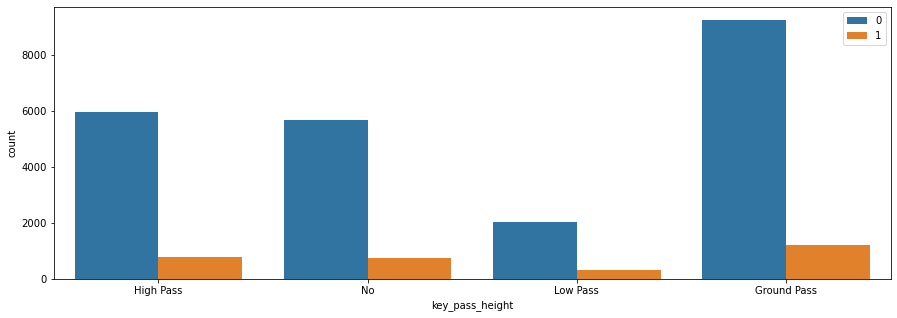

In [18]:
plt.subplots(1, figsize=(15,5))
ax=sns.countplot(x='key_pass_height',hue='goal',data=df)
plt.legend(loc='upper right')

### Prepare data for modelling

We are going to create a simple model  

In [19]:
X = df[['distance', 'angle']]
y = df[['goal']]

Split data into train and test sets

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## 3. Modelling

Logistic Regression model fit

In [21]:
reg = LogisticRegression()
reg.fit(X_train,y_train.values.ravel())

LogisticRegression()

Model predict

In [22]:
y_pred_train = reg.predict_proba(X_train)[:,1]
y_pred_test = reg.predict_proba(X_test)[:,1]

ROC curve calculations

In [23]:
fpr, tpr, thr = roc_curve(y_train, y_pred_train)
fpr1, tpr1, thr1 = roc_curve(y_test, y_pred_test)
fpr2, tpr2, thr2 = roc_curve(y, df[['statsbomb_xg']])
auc = roc_auc_score(y_train, y_pred_train)
auc1 = roc_auc_score(y_test, y_pred_test)
auc2 = roc_auc_score(y, df[['statsbomb_xg']])

Plot ROC curves (AUC)

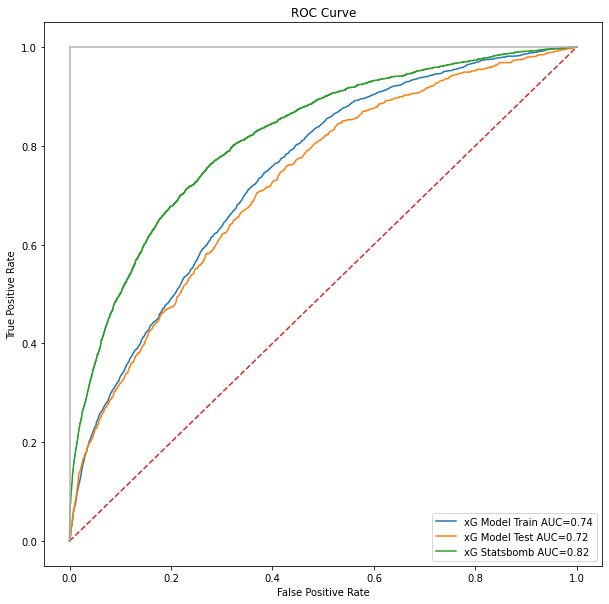

In [24]:
plt.subplots(1, figsize=(10,10))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label="xG Model Train AUC="+str(round(auc,2)))
plt.plot(fpr1, tpr1, label="xG Model Test AUC="+str(round(auc1,2)))
plt.plot(fpr2, tpr2, label="xG Statsbomb AUC="+str(round(auc2,2)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

Plot confusion matrix

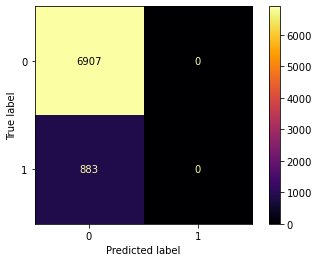

In [25]:
ConfusionMatrixDisplay.from_estimator(reg, X_test, y_test, cmap='inferno')

We can see the model classify every attempt as 'No Goal'

Feature Importance

<BarContainer object of 2 artists>

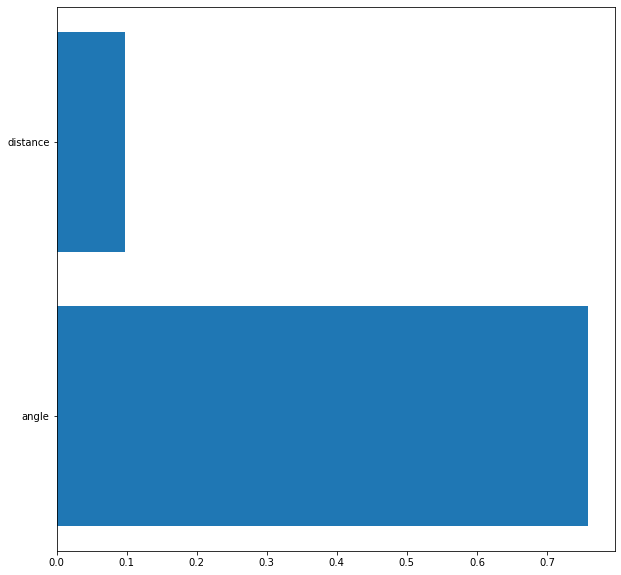

In [26]:
fi = pd.DataFrame({'feature':list(X_train.columns),'importance':[abs(i) for i in reg.coef_[0]]})
fi = fi.sort_values('importance',ascending=False)
plt.subplots(1, figsize=(10,10))
plt.barh(fi['feature'],fi['importance'])

### More complex model

Now we add minute, body_part and first_time variables

In [27]:
X = df[['distance', 'angle', 'minute', 'body_part', 'first_time']]
y = df[['goal']]

Encode categorical variables

In [28]:
categ_cols = ['body_part']   
ohe = OneHotEncoder(sparse=False)
array_hot_encoded = ohe.fit_transform(X[categ_cols])
X_hot_encoded = pd.DataFrame(array_hot_encoded)
X_hot_encoded.columns = ohe.get_feature_names_out()
X_other_cols = X.drop(columns=categ_cols)
X_encoded = pd.concat([X_other_cols, X_hot_encoded], axis=1)

Split data into train and test sets

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3)

Logistic Regression model

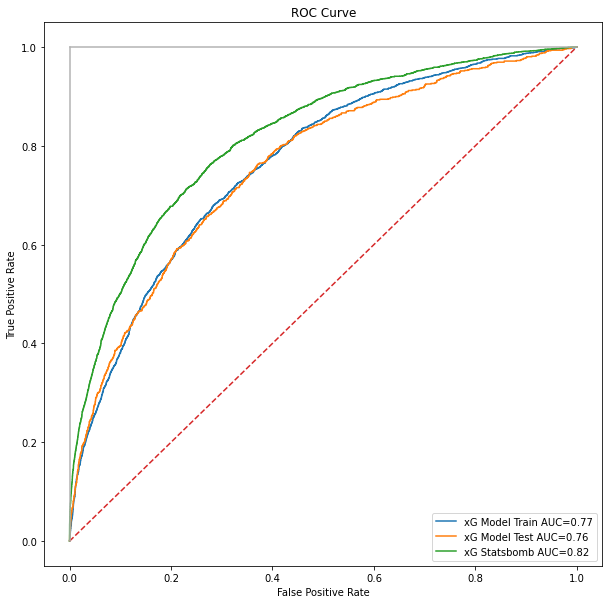

In [30]:
# Fit
reg = LogisticRegression()
reg.fit(X_train,y_train.values.ravel())

# Model predict
y_pred_train = reg.predict_proba(X_train)[:,1]
y_pred_test = reg.predict_proba(X_test)[:,1]

# ROC curve calculations
fpr, tpr, thr = roc_curve(y_train, y_pred_train)
fpr1, tpr1, thr1 = roc_curve(y_test, y_pred_test)
fpr2, tpr2, thr2 = roc_curve(y, df[['statsbomb_xg']])
auc = roc_auc_score(y_train, y_pred_train)
auc1 = roc_auc_score(y_test, y_pred_test)
auc2 = roc_auc_score(y, df[['statsbomb_xg']])

# Plot ROC curves (AUC)
plt.subplots(1, figsize=(10,10))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label="xG Model Train AUC="+str(round(auc,2)))
plt.plot(fpr1, tpr1, label="xG Model Test AUC="+str(round(auc1,2)))
plt.plot(fpr2, tpr2, label="xG Statsbomb AUC="+str(round(auc2,2)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

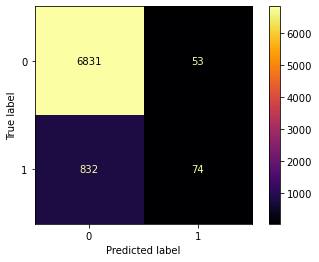

In [31]:
#Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(reg, X_test, y_test, cmap='inferno')

In this matrix we see that the algorithm has started to classify correctly some goals but we are far from our desirable model

Feature Importance

<BarContainer object of 6 artists>

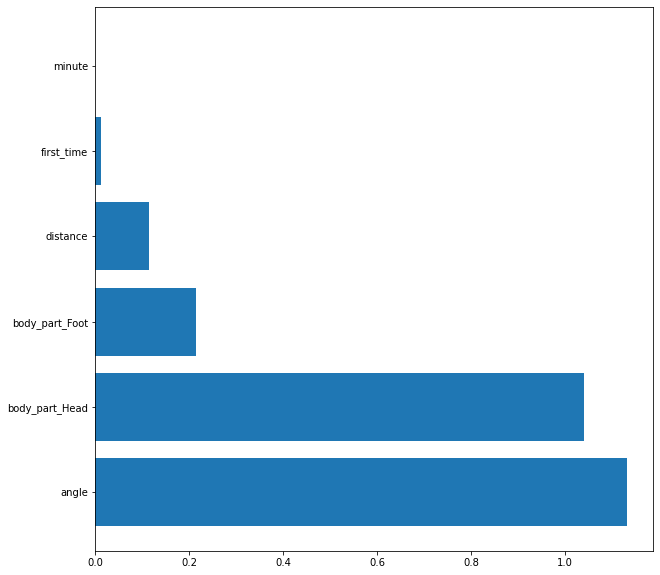

In [32]:
fi = pd.DataFrame({'feature':list(X_train.columns),'importance':[abs(i) for i in reg.coef_[0]]})
fi = fi.sort_values('importance',ascending=False)
plt.subplots(1, figsize=(10,10))
plt.barh(fi['feature'],fi['importance'])

The variable minute has no importance in the model while the angle and body part seem to be critical

### Using every variable

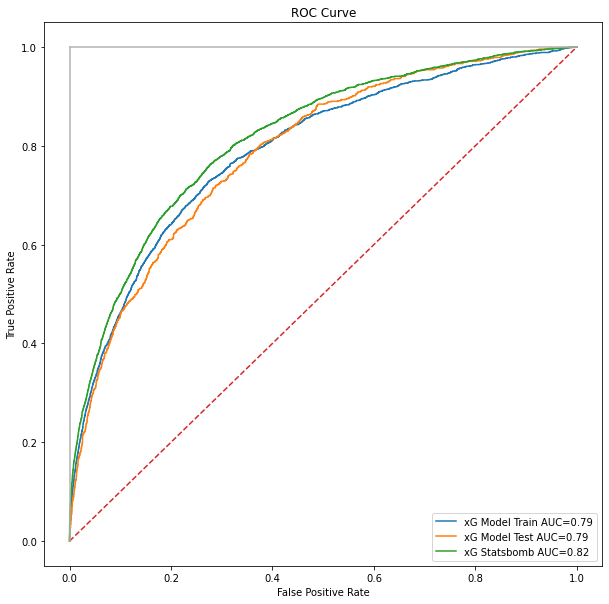

In [33]:
X = df[['x_loc','y_loc','distance', 'angle', 'play_pattern', 'body_part', 'first_time', 'technique', 'key_pass_angle', 'key_pass_length', 'key_pass_height', 'opp_players']]
y = df[['goal']]

# Encode categorical variables
categ_cols = ['play_pattern', 'body_part', 'technique', 'key_pass_height']   
ohe = OneHotEncoder(sparse=False)
array_hot_encoded = ohe.fit_transform(X[categ_cols])
X_hot_encoded = pd.DataFrame(array_hot_encoded)
X_hot_encoded.columns = ohe.get_feature_names_out()
X_other_cols = X.drop(columns=categ_cols)
X_encoded = pd.concat([X_other_cols, X_hot_encoded], axis=1)


# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3)


# We take statsbomb_xg values to compare with our model
coord_test = X_test[['x_loc','y_loc']]
X_train = X_train.drop(columns=(['x_loc','y_loc']))
X_test = X_test.drop(columns=(['x_loc','y_loc']))

# Logistic Regression model fit
reg = LogisticRegression(max_iter=1000)
reg.fit(X_train,y_train.values.ravel())

# Model predict
y_pred_train = reg.predict_proba(X_train)[:,1]
y_pred_test = reg.predict_proba(X_test)[:,1]

coord_test['xG'] =  y_pred_test

# ROC curve calculations
fpr, tpr, thr = roc_curve(y_train, y_pred_train)
fpr1, tpr1, thr1 = roc_curve(y_test, y_pred_test)
fpr2, tpr2, thr2 = roc_curve(y, df[['statsbomb_xg']])
auc = roc_auc_score(y_train, y_pred_train)
auc1 = roc_auc_score(y_test, y_pred_test)
auc2 = roc_auc_score(y, df[['statsbomb_xg']])

# Plot ROC curves (AUC)
plt.subplots(1, figsize=(10,10))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label="xG Model Train AUC="+str(round(auc,2)))
plt.plot(fpr1, tpr1, label="xG Model Test AUC="+str(round(auc1,2)))
plt.plot(fpr2, tpr2, label="xG Statsbomb AUC="+str(round(auc2,2)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

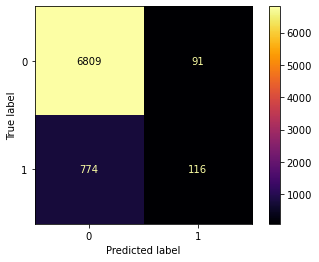

In [34]:
#Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(reg, X_test, y_test, cmap='inferno')

The last model is better than the previous one but we still seeing that it classify the vast majority of the samples as 'No Goal'

<BarContainer object of 28 artists>

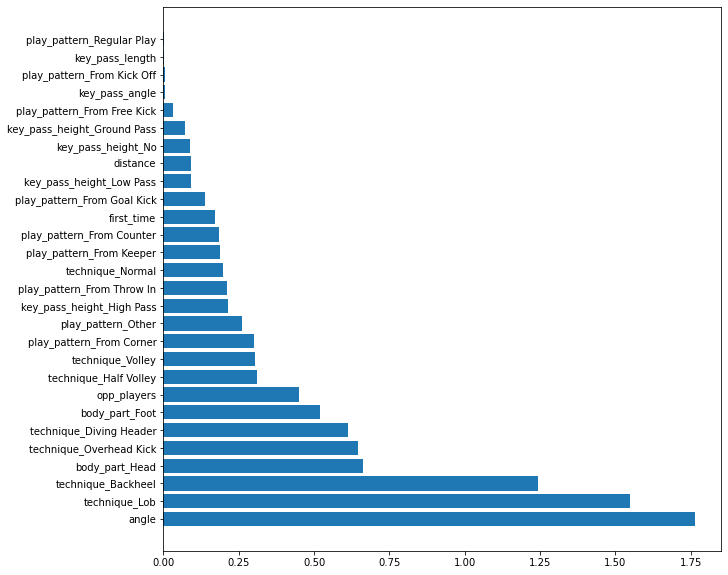

In [35]:
# Feature Importance
fi = pd.DataFrame({'feature':list(X_train.columns),'importance':[abs(i) for i in reg.coef_[0]]})
fi = fi.sort_values('importance',ascending=False)
plt.subplots(1, figsize=(10,10))
plt.barh(fi['feature'],fi['importance'])

## Plot pitch xG

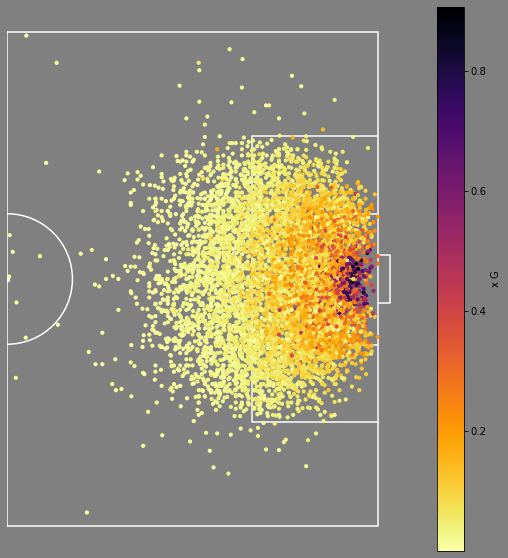

In [36]:
fig, ax = plt.subplots(figsize=(10, 10))
fig.set_facecolor("grey")

draw_pitch(orientation="h",
           aspect="half",
           pitch_color="grey", 
           line_color="white",
           ax=ax)

plt.scatter(coord_test['x_loc'],coord_test['y_loc'],c=coord_test['xG'],cmap='inferno_r', s=10)
cbar = plt.colorbar()
cbar.set_label('x G')

## Class imbalance

As we can see in the  confusion matrices, we have a problem of imbalanced classes. There are 2 main techniques to deal with imbalanced data:
- Undersampling: Removing random records from the majority class, which can cause loss of information.
- Oversampling: Duplicate random samples from the minority class, which can cause overfishing.

Due to the small amount of goals we have, we've decided to do oversampling.

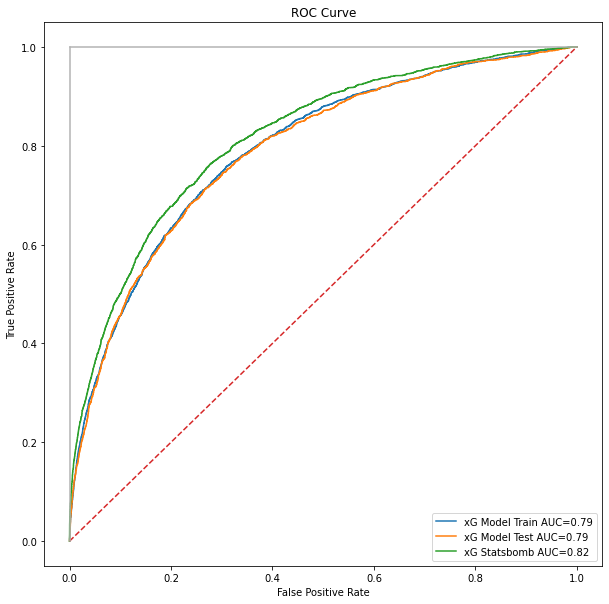

In [37]:
X = df[['x_loc','y_loc','distance', 'angle', 'play_pattern', 'body_part', 'first_time', 'technique', 'key_pass_angle', 'key_pass_length', 'key_pass_height', 'opp_players','statsbomb_xg']]
y = df[['goal']]

#Over Sampling
ros = RandomOverSampler(random_state=42)
X, y = ros.fit_resample(X, y)

# Encode categorical variables
categ_cols = ['play_pattern', 'body_part', 'technique', 'key_pass_height']   
ohe = OneHotEncoder(sparse=False)
array_hot_encoded = ohe.fit_transform(X[categ_cols])
X_hot_encoded = pd.DataFrame(array_hot_encoded)
X_hot_encoded.columns = ohe.get_feature_names_out()
X_other_cols = X.drop(columns=categ_cols)
X_encoded = pd.concat([X_other_cols, X_hot_encoded], axis=1)
X_encoded = X_encoded.drop(columns=['statsbomb_xg'])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3)

# We take statsbomb_xg values to compare with our model
coord_test = X_test[['x_loc','y_loc']]
X_train = X_train.drop(columns=(['x_loc','y_loc']))
X_test = X_test.drop(columns=(['x_loc','y_loc']))

# Logistic Regression model fit
reg = LogisticRegression(max_iter=1000)
reg.fit(X_train,y_train.values.ravel())

# Model predict
y_pred_train = reg.predict_proba(X_train)[:,1]
y_pred_test = reg.predict_proba(X_test)[:,1]

coord_test['xG'] =  y_pred_test

# ROC curve calculations
fpr, tpr, thr = roc_curve(y_train, y_pred_train)
fpr1, tpr1, thr1 = roc_curve(y_test, y_pred_test)
fpr2, tpr2, thr2 = roc_curve(y, X[['statsbomb_xg']])
auc = roc_auc_score(y_train, y_pred_train)
auc1 = roc_auc_score(y_test, y_pred_test)
auc2 = roc_auc_score(y, X[['statsbomb_xg']])

# Plot ROC curves (AUC)
plt.subplots(1, figsize=(10,10))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label="xG Model Train AUC="+str(round(auc,2)))
plt.plot(fpr1, tpr1, label="xG Model Test AUC="+str(round(auc1,2)))
plt.plot(fpr2, tpr2, label="xG Statsbomb AUC="+str(round(auc2,2)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

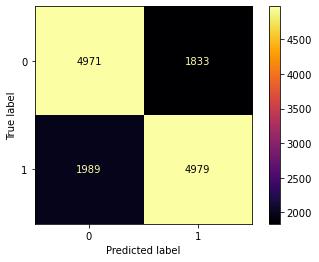

In [38]:
#Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(reg, X_test, y_test, cmap='inferno')

<BarContainer object of 28 artists>

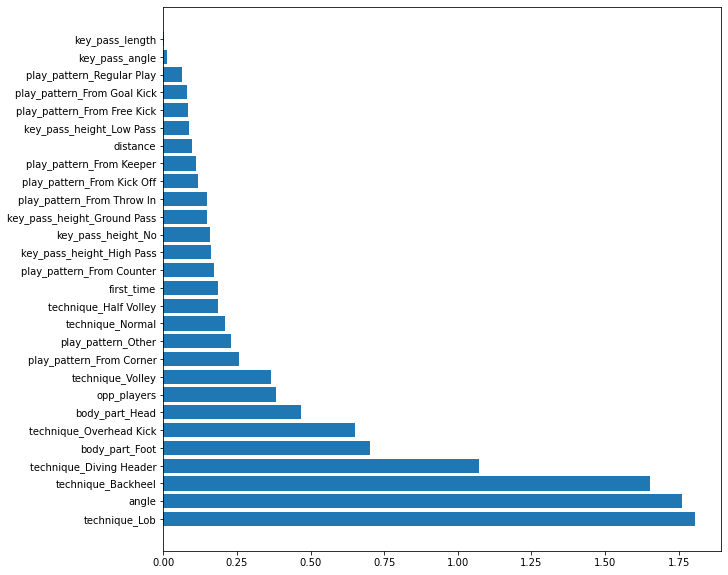

In [39]:
# Feature Importance
fi = pd.DataFrame({'feature':list(X_train.columns),'importance':[abs(i) for i in reg.coef_[0]]})
fi = fi.sort_values('importance',ascending=False)
plt.subplots(1, figsize=(10,10))
plt.barh(fi['feature'],fi['importance'])

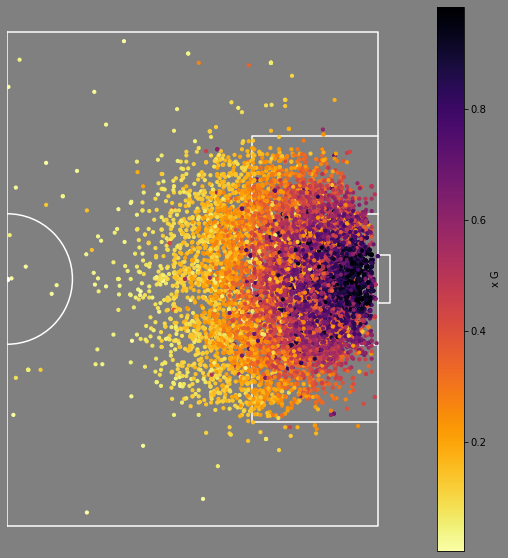

In [40]:
fig, ax = plt.subplots(figsize=(10, 10))
fig.set_facecolor("grey")

draw_pitch(orientation="h",
           aspect="half",
           pitch_color="grey", 
           line_color="white",
           ax=ax)

plt.scatter(coord_test['x_loc'],coord_test['y_loc'],c=coord_test['xG'],cmap='inferno_r', s=10)
cbar = plt.colorbar()
cbar.set_label('x G')

We are going to drop less significant variables such as 'key_pass_angle' and 'key_pass_length'

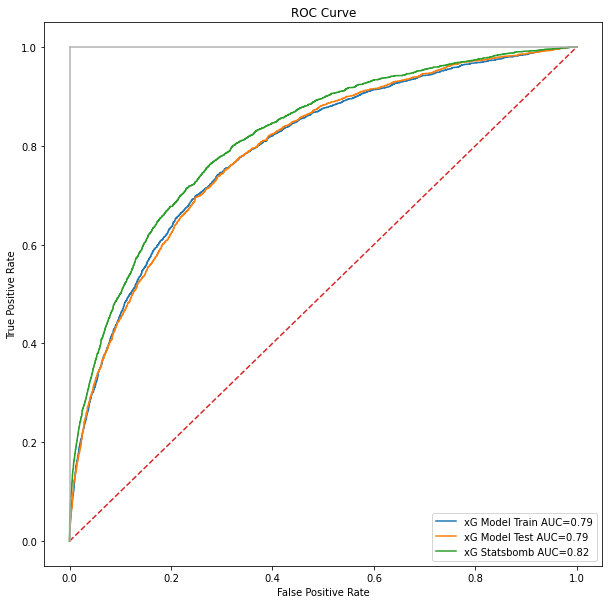

In [41]:
X = df[['x_loc','y_loc','distance', 'angle', 'play_pattern', 'body_part', 'first_time', 'technique', 'key_pass_height', 'opp_players', 'statsbomb_xg']]
y = df[['goal']]

#Over Sampling
ros = RandomOverSampler(random_state=42)
X, y = ros.fit_resample(X, y)

# Encode categorical variables
categ_cols = ['play_pattern', 'body_part', 'technique', 'key_pass_height']   
ohe = OneHotEncoder(sparse=False)
array_hot_encoded = ohe.fit_transform(X[categ_cols])
X_hot_encoded = pd.DataFrame(array_hot_encoded)
X_hot_encoded.columns = ohe.get_feature_names_out()
X_other_cols = X.drop(columns=categ_cols)
X_encoded = pd.concat([X_other_cols, X_hot_encoded], axis=1)
X_encoded = X_encoded.drop(columns=['statsbomb_xg'])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3)

# We take statsbomb_xg values to compare with our model
coord_test = X_test[['x_loc','y_loc']]
X_train = X_train.drop(columns=(['x_loc','y_loc']))
X_test = X_test.drop(columns=(['x_loc','y_loc']))

# Logistic Regression model fit
reg = LogisticRegression(max_iter=1000)
reg.fit(X_train,y_train.values.ravel())

# Model predict
y_pred_train = reg.predict_proba(X_train)[:,1]
y_pred_test = reg.predict_proba(X_test)[:,1]

coord_test['xG'] =  y_pred_test

# ROC curve calculations
fpr, tpr, thr = roc_curve(y_train, y_pred_train)
fpr1, tpr1, thr1 = roc_curve(y_test, y_pred_test)
fpr2, tpr2, thr2 = roc_curve(y, X[['statsbomb_xg']])
auc = roc_auc_score(y_train, y_pred_train)
auc1 = roc_auc_score(y_test, y_pred_test)
auc2 = roc_auc_score(y, X[['statsbomb_xg']])

# Plot ROC curves (AUC)
plt.subplots(1, figsize=(10,10))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label="xG Model Train AUC="+str(round(auc,2)))
plt.plot(fpr1, tpr1, label="xG Model Test AUC="+str(round(auc1,2)))
plt.plot(fpr2, tpr2, label="xG Statsbomb AUC="+str(round(auc2,2)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

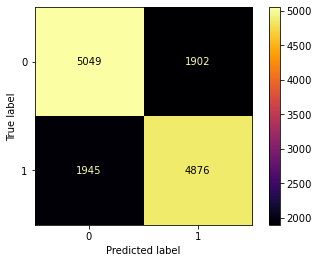

In [42]:
#Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(reg, X_test, y_test, cmap='inferno')

<BarContainer object of 26 artists>

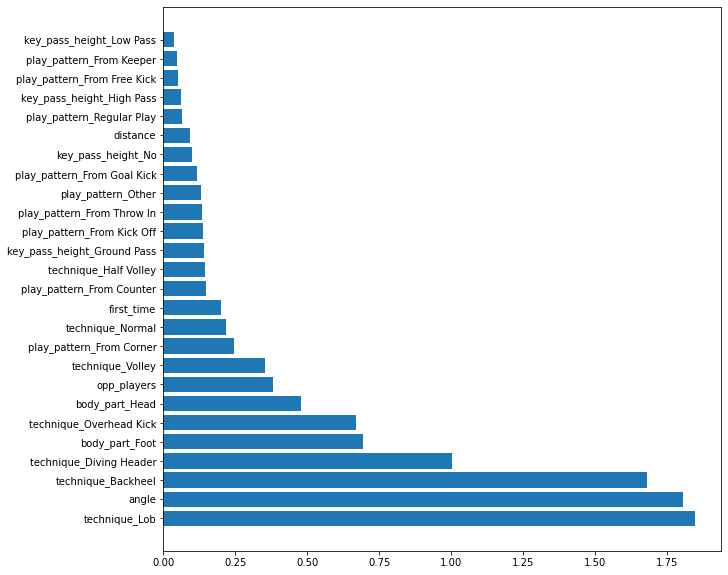

In [43]:
# Feature Importance
fi = pd.DataFrame({'feature':list(X_train.columns),'importance':[abs(i) for i in reg.coef_[0]]})
fi = fi.sort_values('importance',ascending=False)
plt.subplots(1, figsize=(10,10))
plt.barh(fi['feature'],fi['importance'])

We are going to drop variables whose coefficient is less than 0.25

In [44]:
fi25 = fi[fi['importance']<0.25]['feature'] 

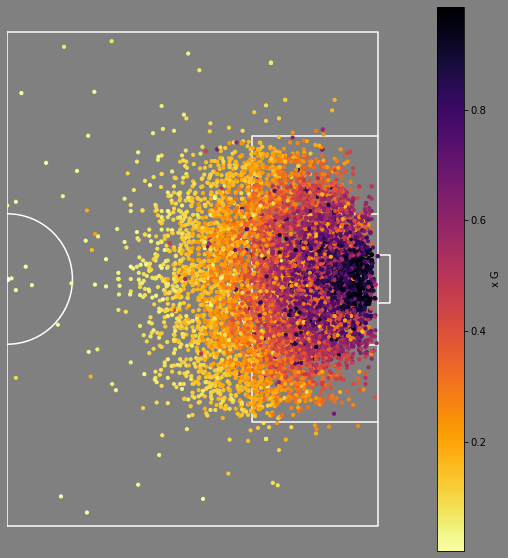

In [45]:
fig, ax = plt.subplots(figsize=(10, 10))
fig.set_facecolor("grey")

draw_pitch(orientation="h",
           aspect="half",
           pitch_color="grey", 
           line_color="white",
           ax=ax)

plt.scatter(coord_test['x_loc'],coord_test['y_loc'],c=coord_test['xG'],cmap='inferno_r', s=10)
cbar = plt.colorbar()
cbar.set_label('x G')

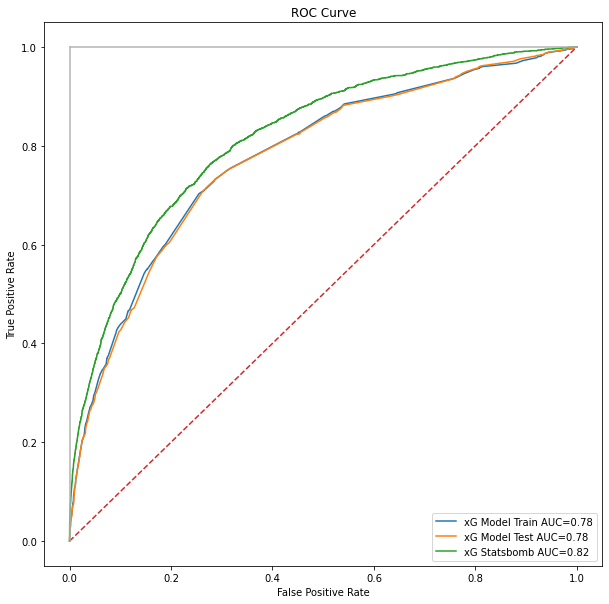

In [46]:
X = df[['x_loc','y_loc','distance', 'angle', 'play_pattern', 'body_part', 'first_time', 'technique', 'key_pass_height', 'opp_players', 'statsbomb_xg']]
y = df[['goal']]

#Over Sampling
ros = RandomOverSampler(random_state=42)
X, y = ros.fit_resample(X, y)

# Encode categorical variables
categ_cols = ['play_pattern', 'body_part', 'technique', 'key_pass_height']   
ohe = OneHotEncoder(sparse=False)
array_hot_encoded = ohe.fit_transform(X[categ_cols])
X_hot_encoded = pd.DataFrame(array_hot_encoded)
X_hot_encoded.columns = ohe.get_feature_names_out()
X_other_cols = X.drop(columns=categ_cols)
X_encoded = pd.concat([X_other_cols, X_hot_encoded], axis=1)
X_encoded = X_encoded.drop(columns=['statsbomb_xg'])

# Drop unimportant variables
X_encoded = X_encoded.drop(columns=fi25)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3)

# We take statsbomb_xg values to compare with our model
coord_test = X_test[['x_loc','y_loc']]
X_train = X_train.drop(columns=(['x_loc','y_loc']))
X_test = X_test.drop(columns=(['x_loc','y_loc']))

# Logistic Regression model fit
reg = LogisticRegression(max_iter=1000)
reg.fit(X_train,y_train.values.ravel())

# Model predict
y_pred_train = reg.predict_proba(X_train)[:,1]
y_pred_test = reg.predict_proba(X_test)[:,1]

coord_test['xG'] =  y_pred_test

# ROC curve calculations
fpr, tpr, thr = roc_curve(y_train, y_pred_train)
fpr1, tpr1, thr1 = roc_curve(y_test, y_pred_test)
fpr2, tpr2, thr2 = roc_curve(y, X[['statsbomb_xg']])
auc = roc_auc_score(y_train, y_pred_train)
auc1 = roc_auc_score(y_test, y_pred_test)
auc2 = roc_auc_score(y, X[['statsbomb_xg']])

# Plot ROC curves (AUC)
plt.subplots(1, figsize=(10,10))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label="xG Model Train AUC="+str(round(auc,2)))
plt.plot(fpr1, tpr1, label="xG Model Test AUC="+str(round(auc1,2)))
plt.plot(fpr2, tpr2, label="xG Statsbomb AUC="+str(round(auc2,2)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

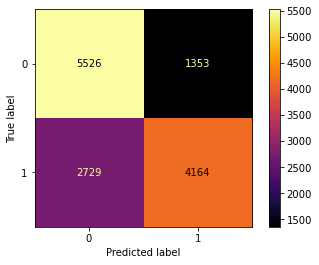

In [47]:
#Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(reg, X_test, y_test, cmap='inferno')

<BarContainer object of 9 artists>

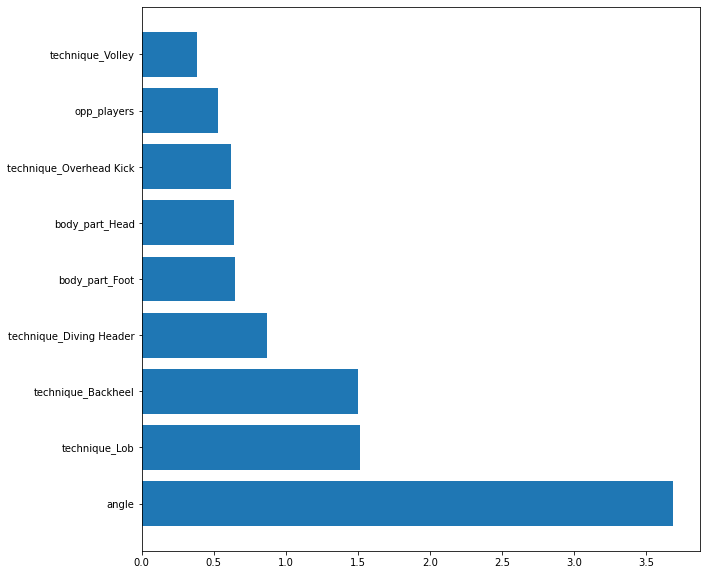

In [48]:
# Feature Importance
fi = pd.DataFrame({'feature':list(X_train.columns),'importance':[abs(i) for i in reg.coef_[0]]})
fi = fi.sort_values('importance',ascending=False)
plt.subplots(1, figsize=(10,10))
plt.barh(fi['feature'],fi['importance'])

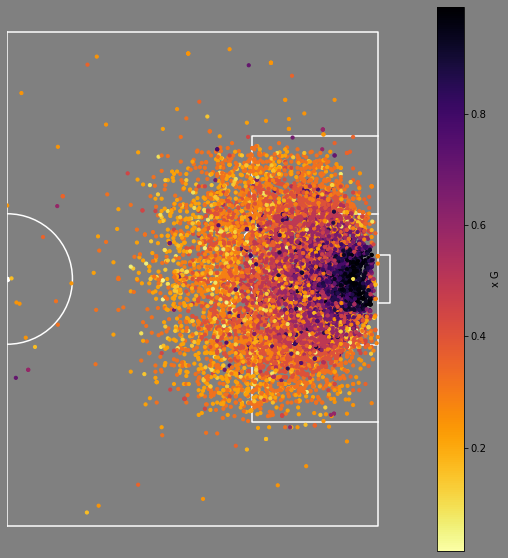

In [49]:
fig, ax = plt.subplots(figsize=(10, 10))
fig.set_facecolor("grey")

draw_pitch(orientation="h",
           aspect="half",
           pitch_color="grey", 
           line_color="white",
           ax=ax)

plt.scatter(coord_test['x_loc'],coord_test['y_loc'],c=coord_test['xG'],cmap='inferno_r', s=10)
cbar = plt.colorbar()
cbar.set_label('x G')

## Create 2 separate models 

<strong>Now we are going to create two different models for kicks and headers since its a relevant feature for the model</strong>

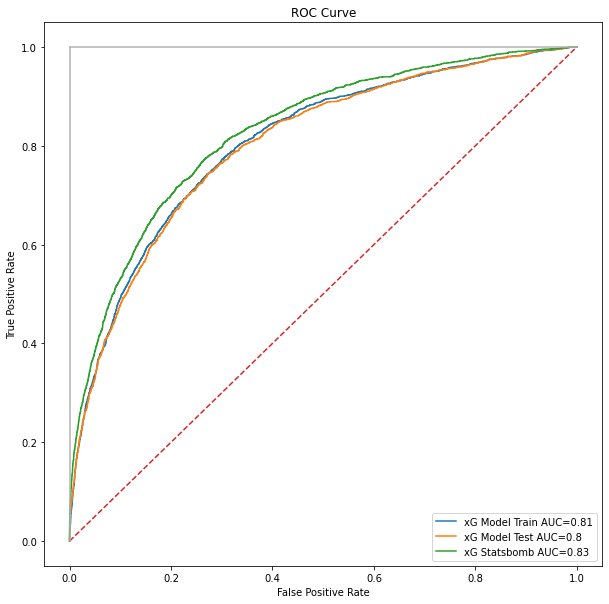

In [50]:
df_foot = df[df['body_part'] == 'Foot'].reset_index(drop=True)

# Prepare data for modelling
X = df_foot[['distance', 'angle', 'play_pattern', 'first_time', 'technique', 'key_pass_height', 'opp_players', 'statsbomb_xg']]
y = df_foot[['goal']]

#Over Sampling
ros = RandomOverSampler(random_state=42)
X, y = ros.fit_resample(X, y)

# Encode categorical variables
categ_cols = ['play_pattern', 'technique', 'key_pass_height']   
ohe = OneHotEncoder(sparse=False)
array_hot_encoded = ohe.fit_transform(X[categ_cols])
X_hot_encoded = pd.DataFrame(array_hot_encoded)
X_hot_encoded.columns = ohe.get_feature_names_out()
X_other_cols = X.drop(columns=categ_cols)
X_encoded = pd.concat([X_other_cols, X_hot_encoded], axis=1)
X_encoded = X_encoded.drop(columns=['statsbomb_xg'])


# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3)


# Logistic Regression model fit
reg = LogisticRegression(max_iter=1000)
reg.fit(X_train,y_train.values.ravel())

# Model predict
y_pred_train = reg.predict_proba(X_train)[:,1]
y_pred_test = reg.predict_proba(X_test)[:,1]

# ROC curve calculations
fpr, tpr, thr = roc_curve(y_train, y_pred_train)
fpr1, tpr1, thr1 = roc_curve(y_test, y_pred_test)
fpr2, tpr2, thr2 = roc_curve(y, X[['statsbomb_xg']])
auc = roc_auc_score(y_train, y_pred_train)
auc1 = roc_auc_score(y_test, y_pred_test)
auc2 = roc_auc_score(y, X[['statsbomb_xg']])

# Plot ROC curves (AUC)
plt.subplots(1, figsize=(10,10))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label="xG Model Train AUC="+str(round(auc,2)))
plt.plot(fpr1, tpr1, label="xG Model Test AUC="+str(round(auc1,2)))
plt.plot(fpr2, tpr2, label="xG Statsbomb AUC="+str(round(auc2,2)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

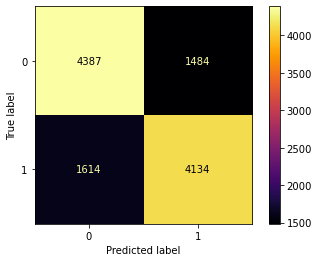

In [51]:
#Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(reg, X_test, y_test, cmap='inferno')

<BarContainer object of 23 artists>

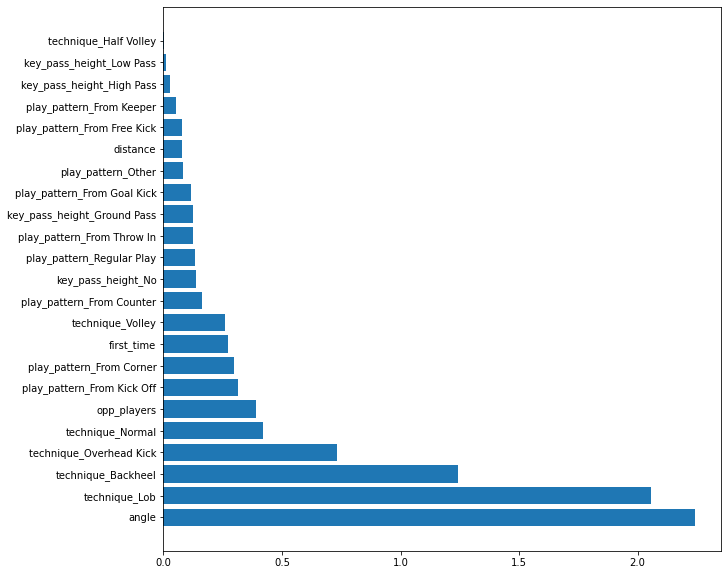

In [52]:
# Feature Importance
fi = pd.DataFrame({'feature':list(X_train.columns),'importance':[abs(i) for i in reg.coef_[0]]})
fi = fi.sort_values('importance',ascending=False)
plt.subplots(1, figsize=(10,10))
plt.barh(fi['feature'],fi['importance'])

<strong>Headers are usually first-time shots and the only reasonable technique is 'Diving Header'.</strong> We decided to drop those columns in the header model.

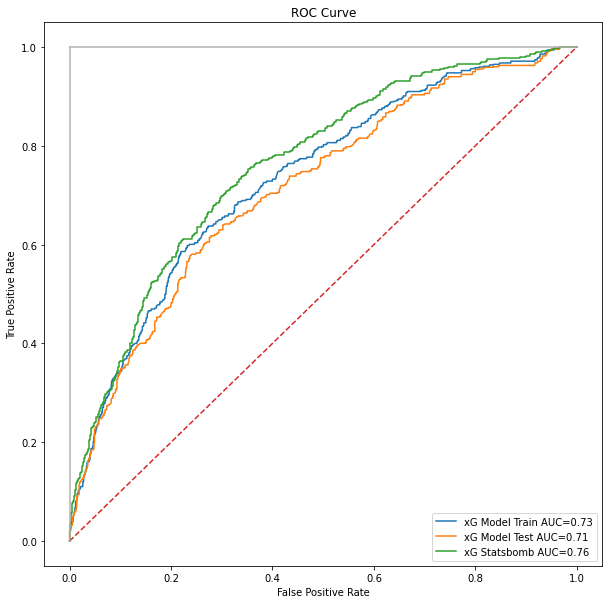

In [53]:
df_head = df[df['body_part'] == 'Head'].reset_index(drop=True)


# Prepare data for modelling
X = df_head[['distance', 'angle', 'play_pattern', 'key_pass_height', 'opp_players','statsbomb_xg']]
y = df_head[['goal']]

#Over Sampling
ros = RandomOverSampler(random_state=42)
X, y = ros.fit_resample(X, y)

# Encode categorical variables
categ_cols = ['play_pattern', 'key_pass_height']   
ohe = OneHotEncoder(sparse=False)
array_hot_encoded = ohe.fit_transform(X[categ_cols])
X_hot_encoded = pd.DataFrame(array_hot_encoded)
X_hot_encoded.columns = ohe.get_feature_names_out()
X_other_cols = X.drop(columns=categ_cols)
X_encoded = pd.concat([X_other_cols, X_hot_encoded], axis=1)
X_encoded = X_encoded.drop(columns=['statsbomb_xg'])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3)


# Logistic Regression model fit
reg = LogisticRegression(max_iter=1000)
reg.fit(X_train,y_train.values.ravel())

# Model predict
y_pred_train = reg.predict_proba(X_train)[:,1]
y_pred_test = reg.predict_proba(X_test)[:,1]

# ROC curve calculations
fpr, tpr, thr = roc_curve(y_train, y_pred_train)
fpr1, tpr1, thr1 = roc_curve(y_test, y_pred_test)
fpr2, tpr2, thr2 = roc_curve(y, X[['statsbomb_xg']])
auc = roc_auc_score(y_train, y_pred_train)
auc1 = roc_auc_score(y_test, y_pred_test)
auc2 = roc_auc_score(y, X[['statsbomb_xg']])

# Plot ROC curves (AUC)
plt.subplots(1, figsize=(10,10))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label="xG Model Train AUC="+str(round(auc,2)))
plt.plot(fpr1, tpr1, label="xG Model Test AUC="+str(round(auc1,2)))
plt.plot(fpr2, tpr2, label="xG Statsbomb AUC="+str(round(auc2,2)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

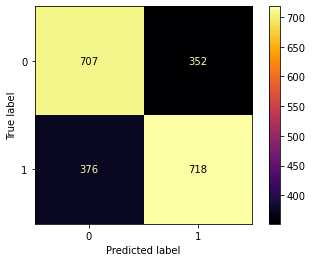

In [54]:
#Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(reg, X_test, y_test, cmap='inferno')

<BarContainer object of 16 artists>

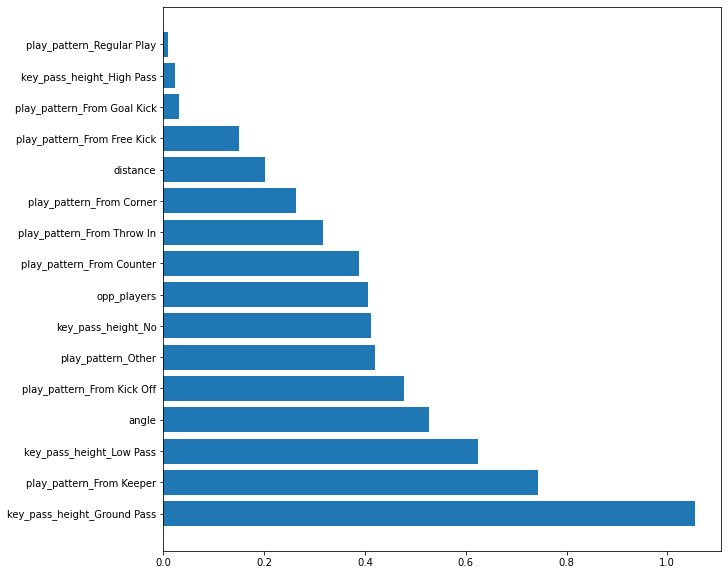

In [55]:
# Feature Importance
fi = pd.DataFrame({'feature':list(X_train.columns),'importance':[abs(i) for i in reg.coef_[0]]})
fi = fi.sort_values('importance',ascending=False)
plt.subplots(1, figsize=(10,10))
plt.barh(fi['feature'],fi['importance'])

We can check that in the headers model the variable 'angle' has less influence on the model, while distance or type of pass are more critical.

Now we are going to try some other different models:

## Random Forest

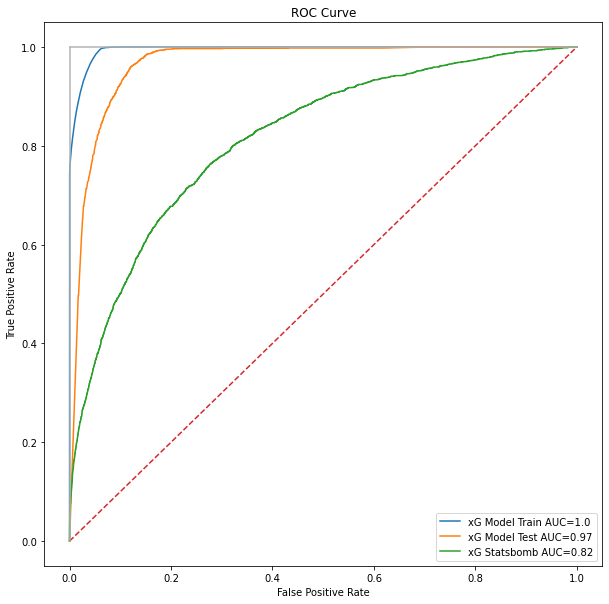

In [56]:
X = df[['x_loc','y_loc','distance', 'angle', 'play_pattern', 'body_part', 'first_time', 'technique', 'key_pass_height','opp_players','statsbomb_xg']]
y = df[['goal']]

#Over Sampling
ros = RandomOverSampler(random_state=42)
X, y = ros.fit_resample(X, y)

# Encode categorical variables
categ_cols = ['play_pattern', 'body_part', 'technique', 'key_pass_height']   
ohe = OneHotEncoder(sparse=False)
array_hot_encoded = ohe.fit_transform(X[categ_cols])
X_hot_encoded = pd.DataFrame(array_hot_encoded)
X_hot_encoded.columns = ohe.get_feature_names_out()
X_other_cols = X.drop(columns=categ_cols)
X_encoded = pd.concat([X_other_cols, X_hot_encoded], axis=1)
X_encoded = X_encoded.drop(columns=['statsbomb_xg'])


# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3)


# We take statsbomb_xg values to compare with our model
coord_test = X_test[['x_loc','y_loc']]
X_train = X_train.drop(columns=(['x_loc','y_loc']))
X_test = X_test.drop(columns=(['x_loc','y_loc']))

rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train,y_train.values.ravel())

# Model predict
y_pred_train = rf.predict_proba(X_train)[:,1]
y_pred_test = rf.predict_proba(X_test)[:,1]

coord_test['xG'] =  y_pred_test

# ROC curve calculations
fpr, tpr, thr = roc_curve(y_train, y_pred_train)
fpr1, tpr1, thr1 = roc_curve(y_test, y_pred_test)
fpr2, tpr2, thr2 = roc_curve(y, X[['statsbomb_xg']])
auc = roc_auc_score(y_train, y_pred_train)
auc1 = roc_auc_score(y_test, y_pred_test)
auc2 = roc_auc_score(y, X[['statsbomb_xg']])

# Plot ROC curves (AUC)
plt.subplots(1, figsize=(10,10))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label="xG Model Train AUC="+str(round(auc,2)))
plt.plot(fpr1, tpr1, label="xG Model Test AUC="+str(round(auc1,2)))
plt.plot(fpr2, tpr2, label="xG Statsbomb AUC="+str(round(auc2,2)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

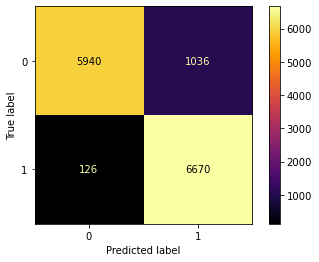

In [57]:
#Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, cmap='inferno')

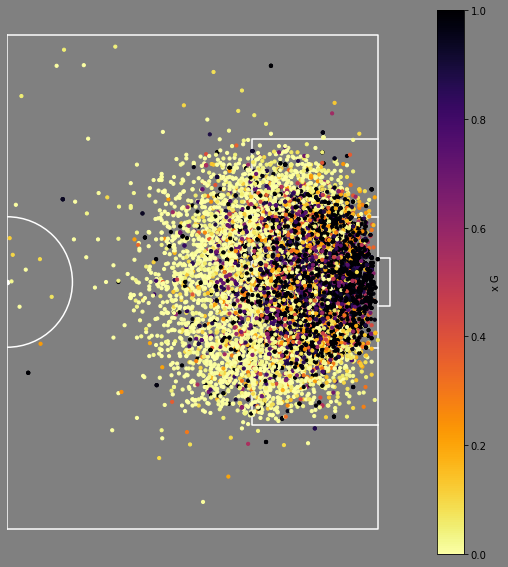

In [58]:
fig, ax = plt.subplots(figsize=(10, 10))
fig.set_facecolor("grey")

draw_pitch(orientation="h",
           aspect="half",
           pitch_color="grey", 
           line_color="white",
           ax=ax)

plt.scatter(coord_test['x_loc'],coord_test['y_loc'],c=coord_test['xG'],cmap='inferno_r', s=10)
cbar = plt.colorbar()
cbar.set_label('x G')

Our model is overfitted, we have to tune some parameters to avoid it.

We are going to set the number of estimators(trees) to 500 (default=100). It's also a good measure to set the maximum features considered in splits between 30%-50% of the total number of features. In addition, we have set the maximum depth of the trees to 5.

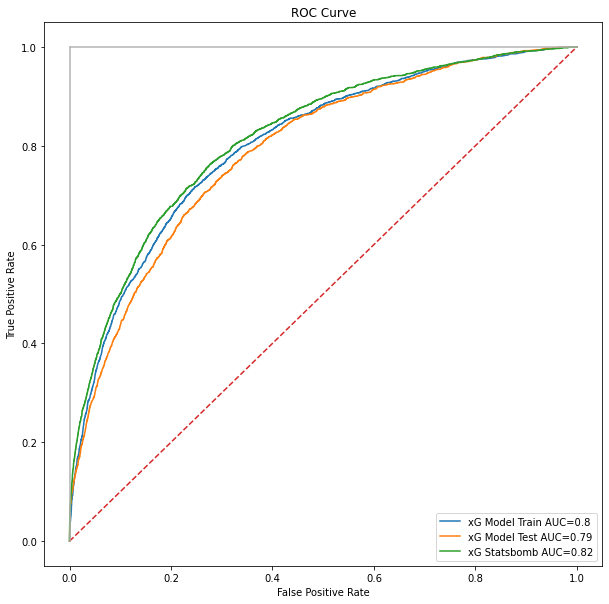

In [59]:
X = df[['x_loc','y_loc','distance', 'angle', 'play_pattern', 'body_part', 'first_time', 'technique', 'key_pass_height', 'opp_players', 'statsbomb_xg']]
y = df[['goal']]

#Over Sampling
ros = RandomOverSampler(random_state=42)
X, y = ros.fit_resample(X, y)

# Encode categorical variables
categ_cols = ['play_pattern', 'body_part', 'technique', 'key_pass_height']   
ohe = OneHotEncoder(sparse=False)
array_hot_encoded = ohe.fit_transform(X[categ_cols])
X_hot_encoded = pd.DataFrame(array_hot_encoded)
X_hot_encoded.columns = ohe.get_feature_names_out()
X_other_cols = X.drop(columns=categ_cols)
X_encoded = pd.concat([X_other_cols, X_hot_encoded], axis=1)
X_encoded = X_encoded.drop(columns=['statsbomb_xg'])


# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3)


# We take statsbomb_xg values to compare with our model
coord_test = X_test[['x_loc','y_loc']]
X_train = X_train.drop(columns=(['x_loc','y_loc']))
X_test = X_test.drop(columns=(['x_loc','y_loc']))

rf = RandomForestClassifier(n_jobs=-1, n_estimators=500, max_features=10, max_depth=5)
rf.fit(X_train,y_train.values.ravel())

# Model predict
y_pred_train = rf.predict_proba(X_train)[:,1]
y_pred_test = rf.predict_proba(X_test)[:,1]

coord_test['xG'] =  y_pred_test

# ROC curve calculations
fpr, tpr, thr = roc_curve(y_train, y_pred_train)
fpr1, tpr1, thr1 = roc_curve(y_test, y_pred_test)
fpr2, tpr2, thr2 = roc_curve(y, X[['statsbomb_xg']])
auc = roc_auc_score(y_train, y_pred_train)
auc1 = roc_auc_score(y_test, y_pred_test)
auc2 = roc_auc_score(y, X[['statsbomb_xg']])

# Plot ROC curves (AUC)
plt.subplots(1, figsize=(10,10))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label="xG Model Train AUC="+str(round(auc,2)))
plt.plot(fpr1, tpr1, label="xG Model Test AUC="+str(round(auc1,2)))
plt.plot(fpr2, tpr2, label="xG Statsbomb AUC="+str(round(auc2,2)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

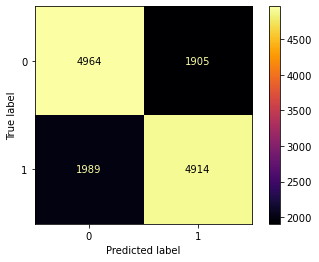

In [60]:
#Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, cmap='inferno')

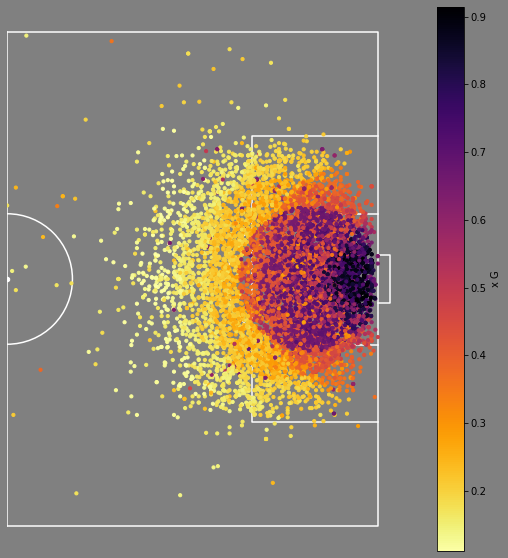

In [61]:
fig, ax = plt.subplots(figsize=(10, 10))
fig.set_facecolor("grey")

draw_pitch(orientation="h",
           aspect="half",
           pitch_color="grey", 
           line_color="white",
           ax=ax)

plt.scatter(coord_test['x_loc'],coord_test['y_loc'],c=coord_test['xG'],cmap='inferno_r', s=10)
cbar = plt.colorbar()
cbar.set_label('x G')

## xGBoost

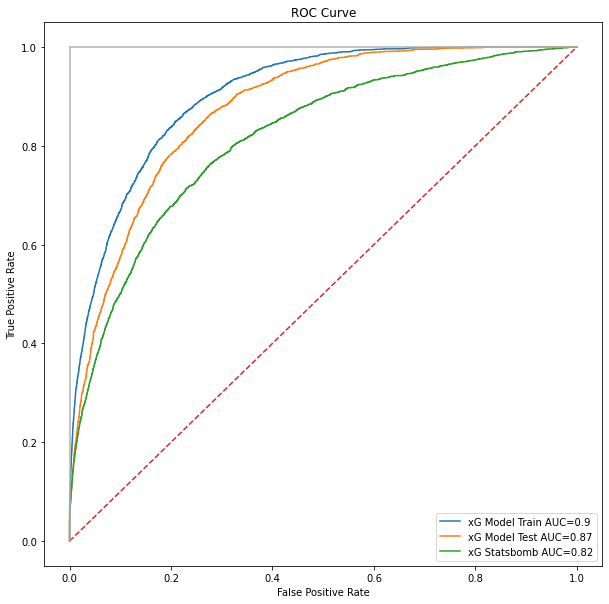

In [62]:
X = df[['x_loc','y_loc','distance', 'angle', 'play_pattern', 'body_part', 'first_time', 'technique', 'key_pass_height', 'opp_players', 'statsbomb_xg']]
y = df[['goal']]

#Over Sampling
ros = RandomOverSampler(random_state=42)
X, y = ros.fit_resample(X, y)

# Encode categorical variables
categ_cols = ['play_pattern', 'body_part', 'technique', 'key_pass_height']   
ohe = OneHotEncoder(sparse=False)
array_hot_encoded = ohe.fit_transform(X[categ_cols])
X_hot_encoded = pd.DataFrame(array_hot_encoded)
X_hot_encoded.columns = ohe.get_feature_names_out()
X_other_cols = X.drop(columns=categ_cols)
X_encoded = pd.concat([X_other_cols, X_hot_encoded], axis=1)
X_encoded = X_encoded.drop(columns=['statsbomb_xg'])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3)

# We take statsbomb_xg values to compare with our model
coord_test = X_test[['x_loc','y_loc']]
X_train = X_train.drop(columns=(['x_loc','y_loc']))
X_test = X_test.drop(columns=(['x_loc','y_loc']))

xgboost = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgboost.fit(X_train,y_train)

# Model predict
y_pred_train = xgboost.predict_proba(X_train)[:,1]
y_pred_test = xgboost.predict_proba(X_test)[:,1]

coord_test['xG'] =  y_pred_test

# ROC curve calculations
fpr, tpr, thr = roc_curve(y_train, y_pred_train)
fpr1, tpr1, thr1 = roc_curve(y_test, y_pred_test)
fpr2, tpr2, thr2 = roc_curve(y, X[['statsbomb_xg']])
auc = roc_auc_score(y_train, y_pred_train)
auc1 = roc_auc_score(y_test, y_pred_test)
auc2 = roc_auc_score(y, X[['statsbomb_xg']])

# Plot ROC curves (AUC)
plt.subplots(1, figsize=(10,10))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label="xG Model Train AUC="+str(round(auc,2)))
plt.plot(fpr1, tpr1, label="xG Model Test AUC="+str(round(auc1,2)))
plt.plot(fpr2, tpr2, label="xG Statsbomb AUC="+str(round(auc2,2)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()


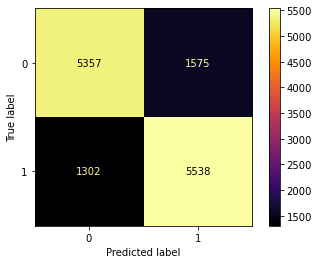

In [63]:
#Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(xgboost, X_test, y_test, cmap='inferno')

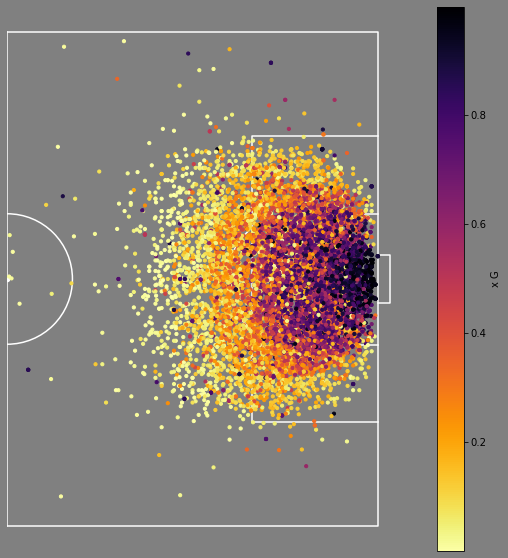

In [64]:
fig, ax = plt.subplots(figsize=(10, 10))
fig.set_facecolor("grey")

draw_pitch(orientation="h",
           aspect="half",
           pitch_color="grey", 
           line_color="white",
           ax=ax)

plt.scatter(coord_test['x_loc'],coord_test['y_loc'],c=coord_test['xG'],cmap='inferno_r', s=10)
cbar = plt.colorbar()
cbar.set_label('x G')

The model is clearly overfitted, something we can do to prevent it is to reduce the maximum depth of the trees.

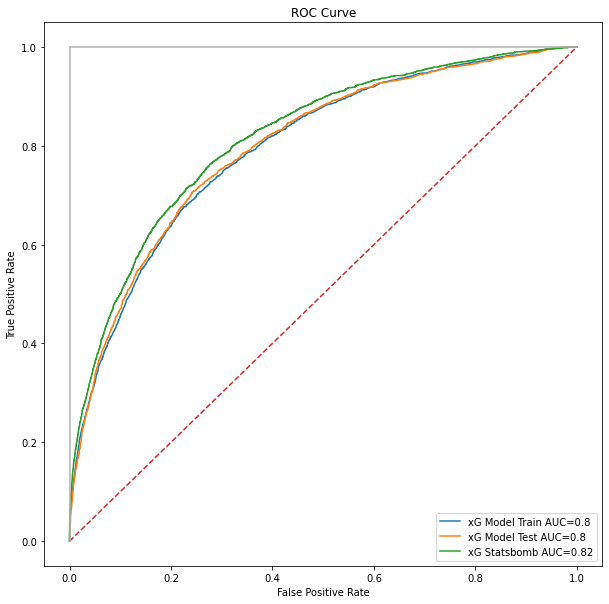

In [65]:
X = df[['x_loc','y_loc','distance', 'angle', 'play_pattern', 'body_part', 'first_time', 'technique', 'key_pass_height', 'opp_players', 'statsbomb_xg']]
y = df[['goal']]

#Over Sampling
ros = RandomOverSampler(random_state=42)
X, y = ros.fit_resample(X, y)

# Encode categorical variables
categ_cols = ['play_pattern', 'body_part', 'technique', 'key_pass_height']   
ohe = OneHotEncoder(sparse=False)
array_hot_encoded = ohe.fit_transform(X[categ_cols])
X_hot_encoded = pd.DataFrame(array_hot_encoded)
X_hot_encoded.columns = ohe.get_feature_names_out()
X_other_cols = X.drop(columns=categ_cols)
X_encoded = pd.concat([X_other_cols, X_hot_encoded], axis=1)
X_encoded = X_encoded.drop(columns=['statsbomb_xg'])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3)

# We take statsbomb_xg values to compare with our model
coord_test = X_test[['x_loc','y_loc']]
X_train = X_train.drop(columns=(['x_loc','y_loc']))
X_test = X_test.drop(columns=(['x_loc','y_loc']))

xgboost = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', max_depth=1)
xgboost.fit(X_train,y_train)

# Model predict
y_pred_train = xgboost.predict_proba(X_train)[:,1]
y_pred_test = xgboost.predict_proba(X_test)[:,1]

coord_test['xG'] =  y_pred_test

# ROC curve calculations
fpr, tpr, thr = roc_curve(y_train, y_pred_train)
fpr1, tpr1, thr1 = roc_curve(y_test, y_pred_test)
fpr2, tpr2, thr2 = roc_curve(y, X[['statsbomb_xg']])
auc = roc_auc_score(y_train, y_pred_train)
auc1 = roc_auc_score(y_test, y_pred_test)
auc2 = roc_auc_score(y, X[['statsbomb_xg']])

# Plot ROC curves (AUC)
plt.subplots(1, figsize=(10,10))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label="xG Model Train AUC="+str(round(auc,2)))
plt.plot(fpr1, tpr1, label="xG Model Test AUC="+str(round(auc1,2)))
plt.plot(fpr2, tpr2, label="xG Statsbomb AUC="+str(round(auc2,2)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()


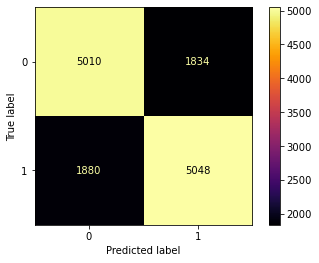

In [66]:
#Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(xgboost, X_test, y_test, cmap='inferno')

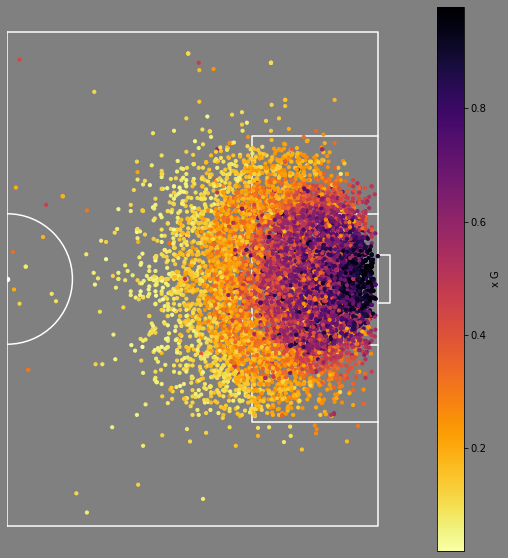

In [67]:
fig, ax = plt.subplots(figsize=(10, 10))
fig.set_facecolor("grey")

draw_pitch(orientation="h",
           aspect="half",
           pitch_color="grey", 
           line_color="white",
           ax=ax)

plt.scatter(coord_test['x_loc'],coord_test['y_loc'],c=coord_test['xG'],cmap='inferno_r', s=10)
cbar = plt.colorbar()
cbar.set_label('x G')

## Conclusions and future work

We have trained 3 different models and the final thought is that you can't achieve a better model than the Logistic Regression in terms of AUC avoiding overfitting.
<br>
We have reached an AUC score around 0.79 compared with the 0.81 achieved by the StatsBomb model.
<br>
We have confirmed that the variable 'angle' seems to be critical in every model.
<br>
I believe that data about players' strong feet would be very useful, but it's not included in any of the open source datasets. So it would be an interesting next step to include this variable in the model